# TP 2 - Redes en el cerebro


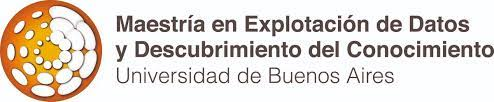

**_Data mining en Ciencia y Tecnología_**  
2do cuatrimestre 2023

## Preprocesamiento de datos

### Carga datos
Cargar el dataset con los datos para cada sujeto y los nombres y coordenadas de las
regiones cerebrales a las que se les registró la actividad.

In [29]:
from pathlib import Path
if not Path("./DataSujetos").is_dir():
  ! wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
  ! unzip -q DataSujetos
  ! rm DataSujetos.zip

In [30]:
if not Path("./aal_extended_withCoords.csv").exists():
  ! wget -q "https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws&dl=1n" -O aal_extended_withCoords.csv

### Descripción de los datos

Sujetos = 18  
Estados de sueño 4 condiciones, una correspondiente a vigilia y 3 a diferentes estadios del sueño no REM (*rapid eye movement*):  
- "W": despierto ("Wake")  
- "N1": sueño "leve"  
- "N2": sueño "intermedio"  
- "N3": sueño "profundo"  

## Manipulación de datos

### Cargar todas las matrices de conectividad

In [31]:
import numpy as np

In [32]:
# diccionario con arrays de los datos de cada sujeto para archivos W_
W = {}
# read all W_*.csv in DataSujetos
for f in Path("./DataSujetos").glob("W_*.csv"):
  W[f.stem] = np.loadtxt(f, delimiter=",")
  n = W[f.stem].shape[0]
  W[f.stem] -= np.diag(np.ones(n))
# quitar el prefijo W_suj
# cambiar key a int
W = {int(k.replace('W_suj','')):v for k,v in W.items()}

In [33]:
# diccionario con arrays de los datos de cada sujeto para archivos N1_
N1 = {}
# read all N1_*.csv in DataSujetos
for f in Path("./DataSujetos").glob("N1_*.csv"):
  N1[f.stem] = np.loadtxt(f, delimiter=",")
  n = N1[f.stem].shape[0]
  N1[f.stem] -= np.diag(np.ones(n))
# quitar el prefijo N1_suj
# cambiar key a int
N1 = {int(k.replace('N1_suj','')):v for k,v in N1.items()}

In [34]:
# diccionario con arrays de los datos de cada sujeto para archivos N2_
N2 = {}
# read all N2_*.csv in DataSujetos
for f in Path("./DataSujetos").glob("N2_*.csv"):
  N2[f.stem] = np.loadtxt(f, delimiter=",")
  n = N2[f.stem].shape[0]
  N2[f.stem] -= np.diag(np.ones(n))
# quitar el prefijo N2_suj
# cambiar key a int
N2 = {int(k.replace('N2_suj','')):v for k,v in N2.items()}

In [35]:
# diccionario con arrays de los datos de cada sujeto para archivos N3_
N3 = {}
# read all N3_*.csv in DataSujetos
for f in Path("./DataSujetos").glob("N3_*.csv"):
  N3[f.stem] = np.loadtxt(f, delimiter=",")
  n = N3[f.stem].shape[0]
  N3[f.stem] -= np.diag(np.ones(n))
# quitar el prefijo N3_suj
# cambiar key a int
N3 = {int(k.replace('N3_suj','')):v for k,v in N3.items()}

## Tarea 1: Visualización

### Promedio de matrices de conectividad para cada estado de sueño

In [36]:
W_mean = np.mean(np.stack(list(W.values())), axis=0)
N1_mean = np.mean(np.stack(list(N1.values())), axis=0)
N2_mean = np.mean(np.stack(list(N2.values())), axis=0)
N3_mean = np.mean(np.stack(list(N3.values())), axis=0)

In [37]:
W_mean.shape

(116, 116)

In [38]:
try:
  import seaborn as sns
  import matplotlib.pyplot as plt
except:
  ! pip install -q seaborn
  import seaborn as sns
  import matplotlib.pyplot as plt

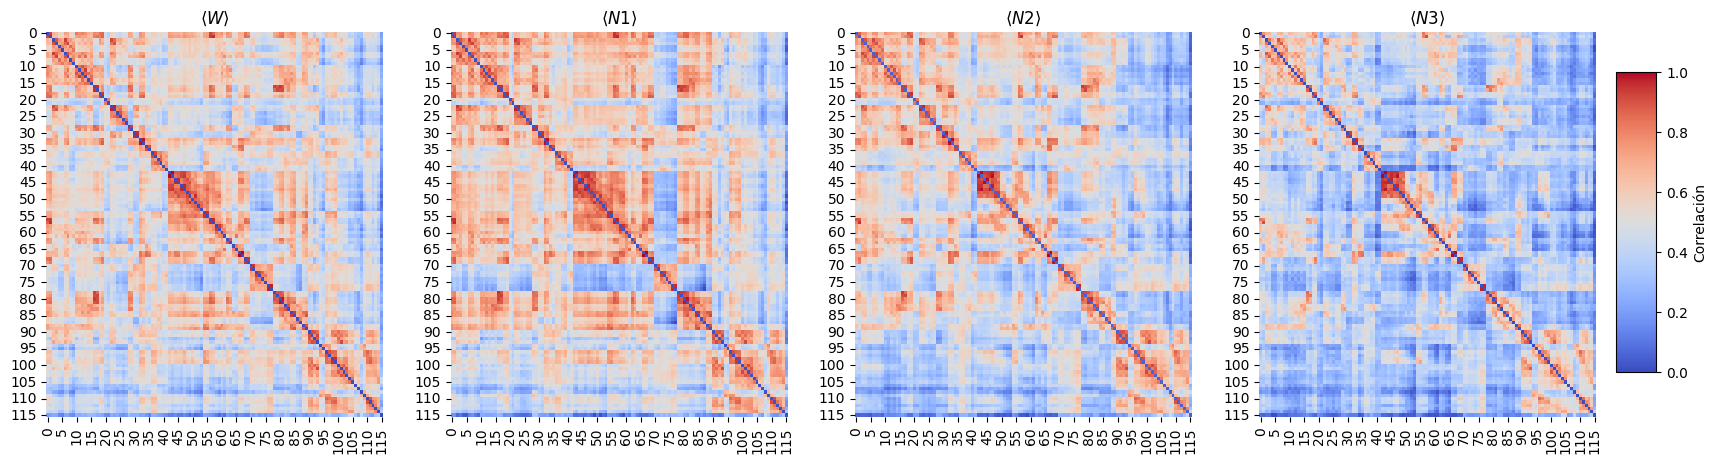

In [69]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sns.heatmap(W_mean, ax=ax[0], cmap="coolwarm", cbar= False)
ax[0].set_title(r"$\langle W \rangle$")
sns.heatmap(N1_mean, ax=ax[1], cmap="coolwarm", cbar= False)
ax[1].set_title(r"$\langle N1 \rangle$")
sns.heatmap(N2_mean, ax=ax[2], cmap="coolwarm", cbar= False)
ax[2].set_title(r"$\langle N2 \rangle$")
sns.heatmap(N3_mean, ax=ax[3], cmap="coolwarm", cbar= False)
ax[3].set_title(r"$\langle N3 \rangle$")

right_edge = ax[3].get_position().xmax  # Right edge of the last subplot
colorbar_axes = fig.add_axes([right_edge + 0.01, 0.2, 0.02, 0.6])  # Position colorbar slightly to the right
sm = plt.cm.ScalarMappable(cmap="coolwarm")
sm.set_array([])
fig.colorbar(sm, label="Correlación", cax= colorbar_axes)

plt.show()

### Sección 3.1 Tamaño de componente gigante en función de umbral de densidad $\delta$
> Primero comparar como varía el tamaño de la componente gigante (es decir, el por-
centaje de nodos que participan en la componente gigante) en función de $\delta$, para todos
los estadíos. Interpretar las curvas obtenidas. ¿Qué nos indican los saltos?

#### Matriz de adyacencia binaria
Transformar dicha matriz de adyacencia pesada a una matriz de adyacencia binaria $A_{i,j}$ que represente una una densidad de enlaces $\delta = 0.08$.
¿Cuál es el valor de umbral de correlación entre pares de regiones que tuvo que utilizar?

Repaso de definiciones
- grado, es el número de enlaces del nodo i, $k_i = \sum_{j=1}^n A_{i,j}$ siendo $n$ el número de nodos
- el número total de enlaces $m = \frac{1}{2} \sum_{i=1}^n k_i = \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n A_{i,j}$, para grafos no dirigidos (el medio es porque se cuenta doble)
- densidad $\rho = \frac{2 m}{n (n-1)}$

In [40]:
def density_to_th(matAdyPesada, densidad):
    # calcula el umbral para producir una densidad determinada
    n = matAdyPesada.shape[0]
    max_links = (n*(n-1))//2
    tril_idx = np.tril_indices(n,-1)
    c = sorted(np.array(list(matAdyPesada[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)* densidad)]

In [41]:
try:
  import networkx as nx
except:
  ! pip install networkx
  import networkx as nx

In [42]:
def matrizAdyacenciaBinaria(matAdyacPesada, densidad):
    # genera la matriza de adyacencia binaria para una densidad dada
    umbral = density_to_th(matAdyacPesada, densidad)
    matAdyacBinaria = matAdyacPesada >= umbral
    return nx.from_numpy_array(matAdyacBinaria)

In [43]:
def get_tamaño_max(matAdyacPesada, densidad):
    # función que obtiene tamaño de componente gigante a partir de matriz de adyacencia pesada y una densidad objetivo
    G = matrizAdyacenciaBinaria(matAdyacPesada, densidad)
    componentes = list(nx.connected_components(G))
    componente_tamaños = [len(componente) for componente in componentes]
    return np.max(componente_tamaños)

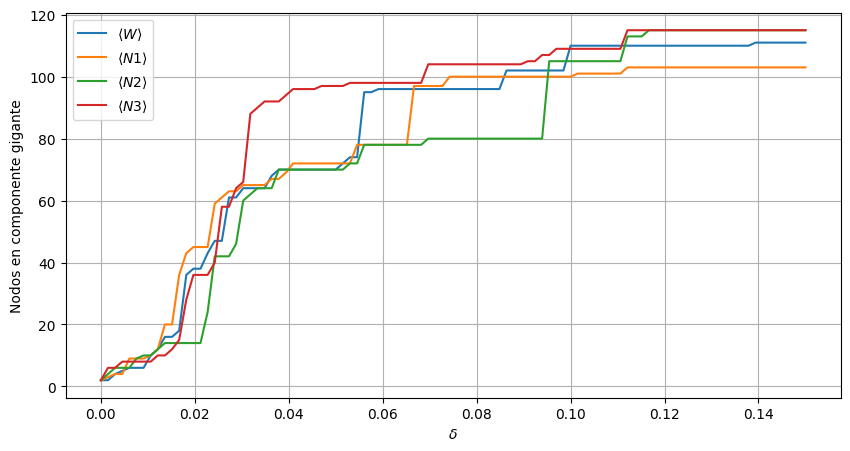

In [44]:
# plot de tamaño de componente gigante en función de densidad para cada matriz de adyacencia pesada promedio
densidades = np.linspace(0.0, 0.15, 100)
tamaños_max = np.zeros((4, len(densidades)))
for i, densidad in enumerate(densidades):
    tamaños_max[0,i] = get_tamaño_max(W_mean, densidad)
    tamaños_max[1,i] = get_tamaño_max(N1_mean, densidad)
    tamaños_max[2,i] = get_tamaño_max(N2_mean, densidad)
    tamaños_max[3,i] = get_tamaño_max(N3_mean, densidad)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(densidades, tamaños_max[0,:], label=r"$\langle W \rangle$")
ax.plot(densidades, tamaños_max[1,:], label=r"$\langle N1 \rangle$")
ax.plot(densidades, tamaños_max[2,:], label=r"$\langle N2 \rangle$")
ax.plot(densidades, tamaños_max[3,:], label=r"$\langle N3 \rangle$")
ax.set_xlabel("$\delta$")
ax.set_ylabel("Nodos en componente gigante")
ax.legend()
ax.grid()
plt.show()


Una inspección visual revela los siguientes saltos
| Estado sueño | Densidad | Salto de nodos en componente gigante |
|--------------|----------|--------------------------------------|
| W            | $\approx 0.055$    | $\approx 75 \rightarrow \approx 95$                                    |
| N1           | $\approx 0.065$    | $\approx 75 \rightarrow \approx 95$                                    |
| N2           | $\approx 0.095$    | $\approx 80 \rightarrow \approx 105$                                    |
| N3           | $\approx 0.03$    | $\approx 65 \rightarrow \approx 90$                                    |

- Interpretar las curvas
- ¿Qué indican los saltos?

### Sección 3.2 | Analizar uno de los saltos
> Elegir uno de los saltos y visualizar los grafos correspondientes para valores de δ justo
antes y justo después del salto. Para esta, y todas las visualizaciones de grafos de este
TP, representar siempre a los nodos en sus respectivas coordenadas cerebrales.

Detalle del salto para $\langle N2 \rangle$.

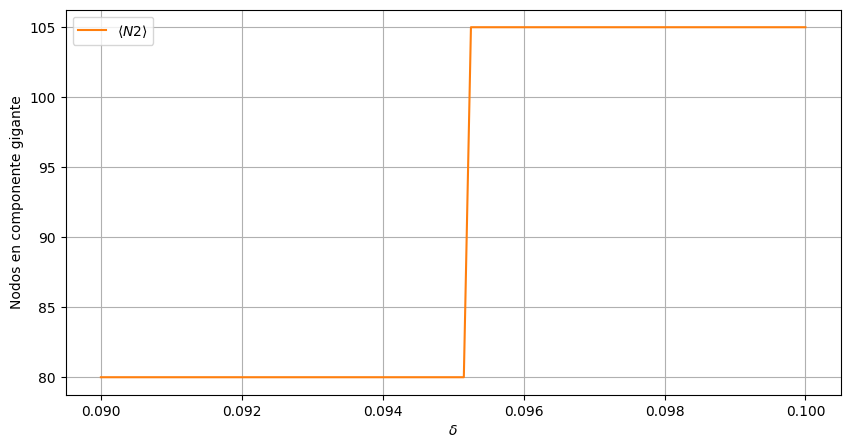

In [45]:
densidades_salto_N2 = np.linspace(0.09, 0.1, 100)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(
  densidades_salto_N2, [(get_tamaño_max(N2_mean, densidad)) for densidad in densidades_salto_N2]
  , label=r"$\langle N2 \rangle$", color="C1"
)
ax.set_xlabel("$\delta$")
ax.set_ylabel("Nodos en componente gigante")
ax.legend()
ax.grid()
plt.show()


In [46]:
import pandas as pd

In [47]:
# Carga de coordenadas de regiones
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]

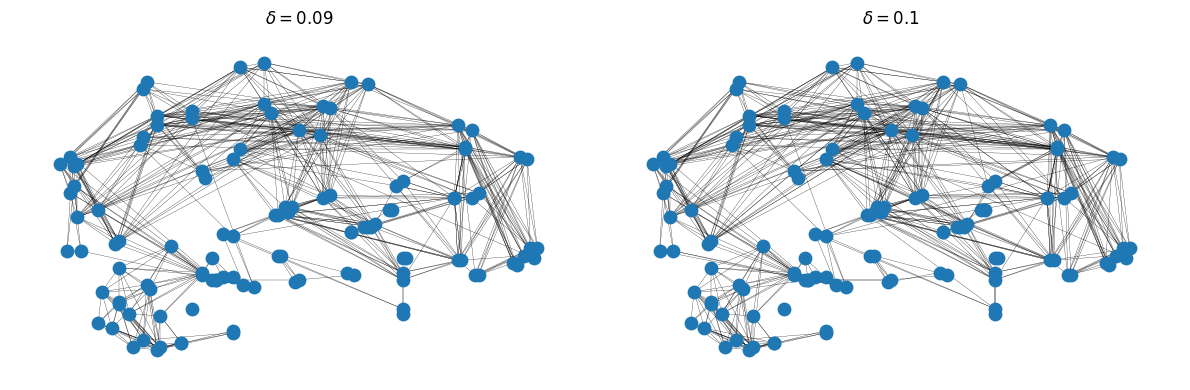

In [48]:
# Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada nodo de acuerdo a su coeficiente de clustering Ci
fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()
layout = dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

densidad_objetivo = 0.09
G = matrizAdyacenciaBinaria(N2_mean, densidad_objetivo)
#plt.box(False)
ax[0].set_frame_on(False)
nx.draw_networkx(G, layout,
  with_labels = False, node_size = 80, width = 0.2, ax=ax[0]
)
ax[0].set_title(r"$\delta = 0.09$")

densidad_objetivo = 0.1
G = matrizAdyacenciaBinaria(N2_mean, densidad_objetivo)
ax[1].set_frame_on(False)
nx.draw_networkx(G, layout,
  with_labels = False, node_size = 80, width = 0.2, ax=ax[1]
)
ax[1].set_title(r"$\delta = 0.1$")

fig.tight_layout()

Es muy sutil, pero se ven más conexiones a la derecha en particular en la zona donde hay ya bastante densidad en el de la izquierda.
Si interpreto bien las coordenadas son notarios los nuevos enlaces que van a la corteza frontal.

### Sección 3.3
Graficar como varía el grado medio, el coeficiente de clustering medio, y la eficiencia
global en función de δ. Interpretar curvas.

#### Grado medio $\langle k \rangle$

In [49]:
def get_grado_promedio(matAdyacPesada, densidad):
    # grado (número de enlaces) promedio de los nodos de la red producto de hacer binaria matriz de adyacencia pesada con el umbral que corresponde a una densidad dada
    G = matrizAdyacenciaBinaria(matAdyacPesada, densidad)
    grados_dict = G.degree() # Diccionario con ID de nodo y su grado
    nodos = G.nodes()
    grados_por_nodo = np.asarray([grados_dict[nodo] for nodo in nodos]) # array con grados de cada nodo
    return np.mean(grados_por_nodo)

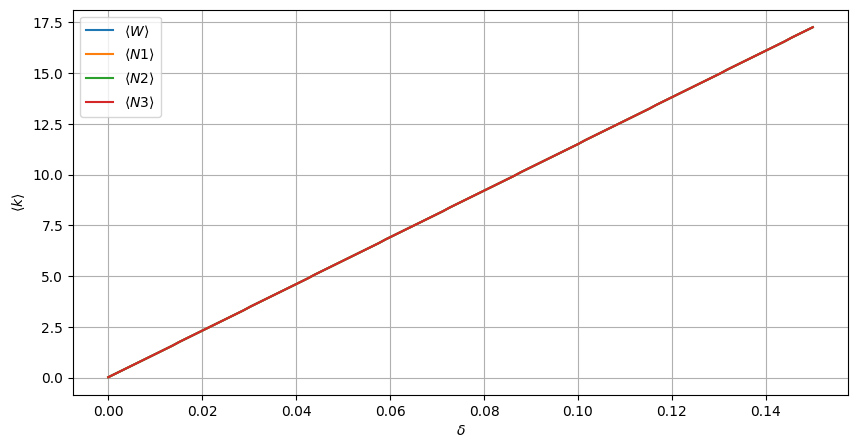

In [50]:
# plot de grado medio en función de densidad para cada matriz de adyacencia pesada promedio
densidades = np.linspace(0.0, 0.15, 100)
grado_promedio = np.zeros((4, len(densidades)))
for i, densidad in enumerate(densidades):
    grado_promedio[0,i] = get_grado_promedio(W_mean, densidad)
    grado_promedio[1,i] = get_grado_promedio(N1_mean, densidad)
    grado_promedio[2,i] = get_grado_promedio(N2_mean, densidad)
    grado_promedio[3,i] = get_grado_promedio(N3_mean, densidad)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(densidades, grado_promedio[0,:], label=r"$\langle W \rangle$")
ax.plot(densidades, grado_promedio[1,:], label=r"$\langle N1 \rangle$")
ax.plot(densidades, grado_promedio[2,:], label=r"$\langle N2 \rangle$")
ax.plot(densidades, grado_promedio[3,:], label=r"$\langle N3 \rangle$")
ax.set_xlabel("$\delta$")
ax.set_ylabel(r"$\langle k \rangle$")
ax.legend()
ax.grid()
plt.show()


Esto es lógico pues la definición de densidad se da en función de la cantidad de enlaces que hay en la red, por lo que a mayor densidad, mayor cantidad de enlaces y por lo tanto mayor grado promedio.
La expresión que las relaciona es $\delta = \frac{2L}{N(N-1)}$, donde $p$ es la densidad, $L$ es la cantidad de enlaces y $N$ es la cantidad de nodos. Si despejamos $L$ de esta expresión y la reemplazamos en la expresión de grado promedio, obtenemos que $\langle k \rangle = \frac{2 \delta (N-1)}{N}$, que es una función lineal de $\delta$.

#### Coeficiente de clustering promedio

In [51]:
def get_clustering_promedio(matAdyacPesada, densidad):
    # coeficiente de clustering promedio de los nodos de la red producto de hacer binaria matriz de adyacencia pesada con el umbral que corresponde a una densidad dada
    G = matrizAdyacenciaBinaria(matAdyacPesada, densidad)
    clustering_dict = nx.clustering(G) # Diccionario con ID de nodo y su coeficiente de clustering
    nodos = G.nodes()
    clustering_por_nodo = np.asarray([clustering_dict[nodo] for nodo in nodos]) # array con coeficientes de clustering de cada nodo
    return np.mean(clustering_por_nodo)

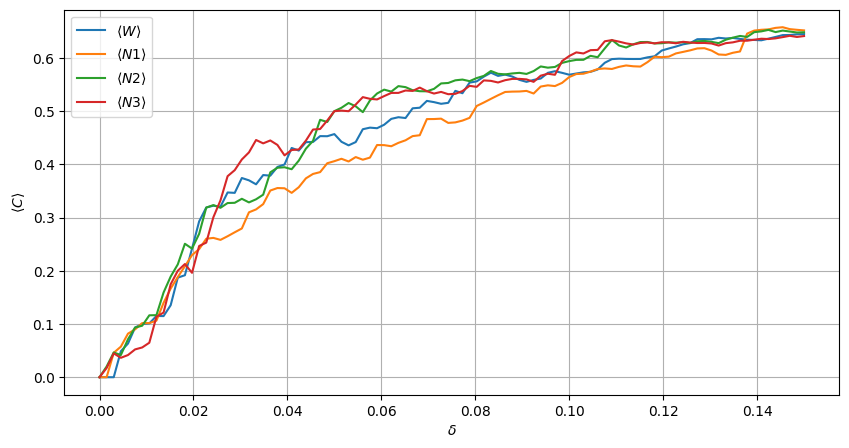

In [52]:
# plot de clustering promedio en función de densidad para cada matriz de adyacencia pesada promedio
densidades = np.linspace(0.0, 0.15, 100)
clustering_promedio = np.zeros((4, len(densidades)))
for i, densidad in enumerate(densidades):
    clustering_promedio[0,i] = get_clustering_promedio(W_mean, densidad)
    clustering_promedio[1,i] = get_clustering_promedio(N1_mean, densidad)
    clustering_promedio[2,i] = get_clustering_promedio(N2_mean, densidad)
    clustering_promedio[3,i] = get_clustering_promedio(N3_mean, densidad)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(densidades, clustering_promedio[0,:], label=r"$\langle W \rangle$")
ax.plot(densidades, clustering_promedio[1,:], label=r"$\langle N1 \rangle$")
ax.plot(densidades, clustering_promedio[2,:], label=r"$\langle N2 \rangle$")
ax.plot(densidades, clustering_promedio[3,:], label=r"$\langle N3 \rangle$")
ax.set_xlabel("$\delta$")
ax.set_ylabel(r"$\langle C \rangle$")
ax.legend()
ax.grid()


#### Eficencia global

In [53]:
def get_eficiencia_global(matAdyacPesada, densidad):
    # eficiencia global de la red producto de hacer binaria matriz de adyacencia pesada con el umbral que corresponde a una densidad dada
    G = matrizAdyacenciaBinaria(matAdyacPesada, densidad)
    return nx.global_efficiency(G)

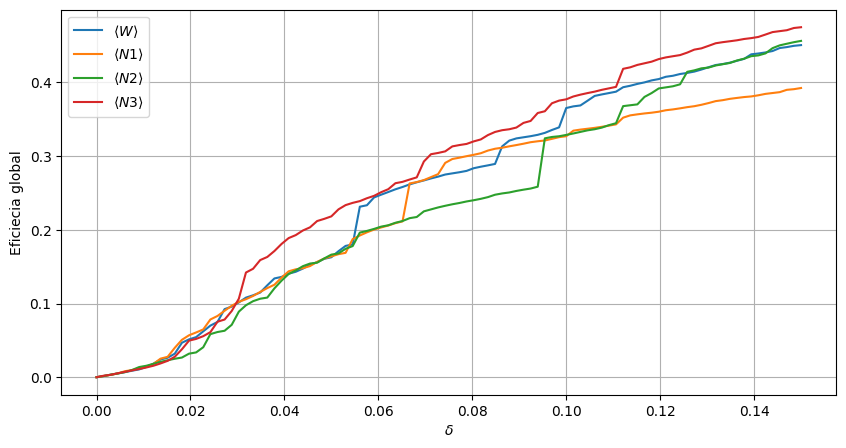

In [54]:
# plot de eficiencia global en función de densidad para cada matriz de adyacencia pesada promedio
densidades = np.linspace(0.0, 0.15, 100)
eficiencia_global = np.zeros((4, len(densidades)))
for i, densidad in enumerate(densidades):
    eficiencia_global[0,i] = get_eficiencia_global(W_mean, densidad)
    eficiencia_global[1,i] = get_eficiencia_global(N1_mean, densidad)
    eficiencia_global[2,i] = get_eficiencia_global(N2_mean, densidad)
    eficiencia_global[3,i] = get_eficiencia_global(N3_mean, densidad)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(densidades, eficiencia_global[0,:], label=r"$\langle W \rangle$")
ax.plot(densidades, eficiencia_global[1,:], label=r"$\langle N1 \rangle$")
ax.plot(densidades, eficiencia_global[2,:], label=r"$\langle N2 \rangle$")
ax.plot(densidades, eficiencia_global[3,:], label=r"$\langle N3 \rangle$")
ax.set_xlabel("$\delta$")
ax.set_ylabel("Eficiecia global")
ax.legend()
ax.grid()
plt.show()

### Sección 3.4 
> Para un valor de $\delta = 0.12$ visualizar el grafo de cada estadío, donde el color del nodo
$i$ esté dado a su centralidad de autovector $c_i^{\mathrm{eigen}}$, y su tamaño sea proporcional a $\alpha c_i^{\mathrm{eigen}}$ (donde $\alpha$ es una constante que debemos elegir para ayudar la visualización). ¿Se observan cambios entre estadíos?

In [55]:
def get_node_centrality(matAdyacPesada, densidad):
    # centralidad de los nodos de la red producto de hacer binaria matriz de adyacencia pesada con el umbral que corresponde a una densidad dada
    G = matrizAdyacenciaBinaria(matAdyacPesada, densidad)
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality
    return nx.eigenvector_centrality(G)

/tmp/ipykernel_348251/3051163812.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('coolwarm')
/tmp/ipykernel_348251/3051163812.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


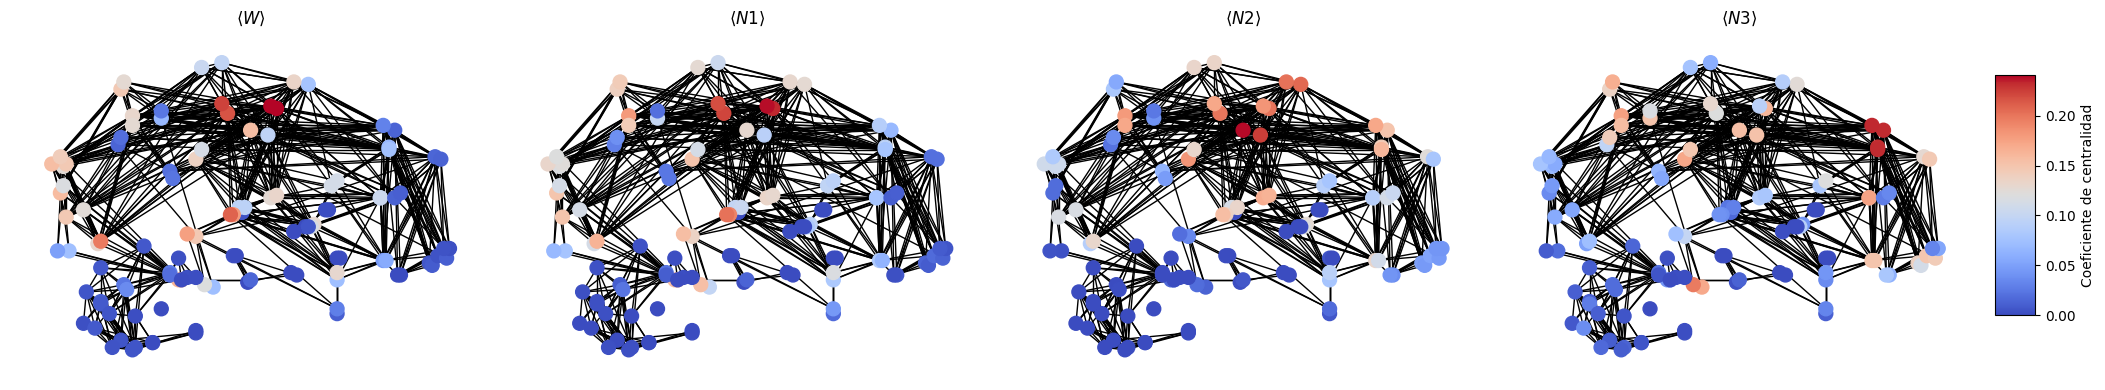

In [70]:

densidad_objetivo = 0.12

fig, ax = plt.subplots(1,4, figsize=(20,4))
color_map = plt.cm.get_cmap('coolwarm')

# W_mean
centralidad_por_nodo = get_node_centrality(W_mean, densidad_objetivo)
n_color_normalizado = list(centralidad_por_nodo.values())
vmin = min(n_color_normalizado)
vmax = max(n_color_normalizado)
nx.draw(G, layout, node_color = n_color_normalizado,
  with_labels = False, node_size = 100,
  cmap = color_map,
  vmin = vmin, vmax = vmax,
  ax=ax[0], 
  #label=r"$\langle W \rangle$"
)
ax[0].set_title(r"$\langle W \rangle$")

# N1_mean, mismos vmin y vmas para la escala de colores
centralidad_por_nodo = get_node_centrality(N1_mean, densidad_objetivo)
n_color_normalizado = list(centralidad_por_nodo.values())
nx.draw(G, layout, node_color = n_color_normalizado,
  with_labels = False, node_size = 100, 
  cmap = color_map,
  vmin = vmin, vmax = vmax,
  ax=ax[1],
  #label=r"$\langle N1 \rangle$"
)
ax[1].set_title(r"$\langle N1 \rangle$")

# N2_mean, mismos vmin y vmas para la escala de colores
centralidad_por_nodo = get_node_centrality(N2_mean, densidad_objetivo)
n_color_normalizado = list(centralidad_por_nodo.values())
nx.draw(G, layout, node_color = n_color_normalizado,
  with_labels = False, node_size = 100,
  cmap = color_map,
  vmin = vmin, vmax = vmax,
  ax=ax[2],
  #label=r"$\langle N2 \rangle$"
)
ax[2].set_title(r"$\langle N2 \rangle$")

# N3_mean, mismos vmin y vmas para la escala de colores
centralidad_por_nodo = get_node_centrality(N3_mean, densidad_objetivo)
n_color_normalizado = list(centralidad_por_nodo.values())
nx.draw(G, layout, node_color = n_color_normalizado,
  with_labels = False, node_size = 100,
  cmap = color_map,
  vmin = vmin, vmax = vmax,
  ax=ax[3],
  #label=r"$\langle N3 \rangle$"
)
ax[3].set_title(r"$\langle N3 \rangle$")

right_edge = ax[3].get_position().xmax  # Right edge of the last subplot
cax = fig.add_axes([right_edge + 0.1, 0.2, 0.02, 0.6])  # Position colorbar slightly to the right
sm = plt.cm.ScalarMappable(cmap = color_map, norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm.set_array([])
fig.colorbar(sm, label = 'Coeficiente de centralidad', cax = cax)
# cbar = plt.colorbar(sm, ax=ax[3])
# cbar.set_label('Coeficiente de centralidad', rotation=270, labelpad=25, fontsize=15)

fig.tight_layout()
plt.show()


Se ven cambios:
- De W a N1, se ve que nodos en la corteza anterior del lóbulo occipital pierden centralidad.
- De N1 a N2, ganan entralidad nodos en la parte superior del lóbulo frontal y en la parte central fronteriza entre el lóbulo parietal y frontal.
- De N2 a N3, pierden centralidad los de la parte central fronteriza entre lóbulos parietal y frontal en favor de aquellos en la corteza de este último. 


## Tarea 2: Comunidades

### Variación de coeficiente de modularidad en función de δ. Curvas promedio (entre individuos)

In [57]:
# Obtener coef de modularidad para cada matriz binarizada según diferentes valores de delta.

densidades_mod = np.linspace(0.0,0.15,16)

# from community import community_louvain as cl

def modularidad_grafos(matAdyacPesada, densidad):
    G = matrizAdyacenciaBinaria(matAdyacPesada, densidad)
    # M = cl.best_partition(G) # Malena
    M = nx.community.louvain_communities(G)
    # devuelve coef de modularidad y numero de nodos y enlaces para cada grafo
    # return cl.modularity(M,G), G.number_of_edges() # Malena
    return nx.community.modularity(G, M), G.number_of_edges()

mod_W = np.zeros((len(W), len(densidades_mod)))
edges_W = np.zeros((len(W),len(densidades_mod)))

for i, densidad in enumerate(densidades_mod):
    for j, grafo in W.items():
      mod_W[j-1,i],edges_W[j-1,i] = modularidad_grafos(grafo, densidad)

mod_N1 = np.zeros((len(N1), len(densidades_mod)))
#edges_N1 = np.zeros((len(N1),len(densidades_mod)))

for i, densidad in enumerate(densidades_mod):
    for j, grafo in N1.items():
      mod_N1[j-1,i],_ = modularidad_grafos(grafo, densidad)

mod_N2 = np.zeros((len(N2), len(densidades_mod)))
#edges_N2 = np.zeros((len(N2),len(densidades_mod)))

for i, densidad in enumerate(densidades_mod):
    for j, grafo in N2.items():
      mod_N2[j-1,i],_  = modularidad_grafos(grafo, densidad)

mod_N3 = np.zeros((len(N3), len(densidades_mod)))
#edges_N3 = np.zeros((len(N3),len(densidades_mod)))

for i, densidad in enumerate(densidades_mod):
    for j, grafo in N3.items():
      mod_N3[j-1,i],_  = modularidad_grafos(grafo, densidad)

In [58]:
# Defino una función que obtiene un grafo random con = nodos y enlaces que los grafos de base para diferentes densidades y calcula su coef de modularidad

def modularidad_grafos_random(cant_nodos, cant_enlaces):
  G = nx.gnm_random_graph(cant_nodos,cant_enlaces)
  # M = cl.best_partition(G) # Malena
  M = nx.community.louvain_communities(G)
  # devuelve coef de modularidad y numero de nodos y enlaces para cada grafo
  # return cl.modularity(M,G) # Malena
  return nx.community.modularity(G, M)

### Genero grafos random usando n° de nodos y enlaces obtenidos

In [59]:
mod_rand = np.zeros((len(edges_W), len(edges_W[0])))

for i in range(0,len(mod_rand[0])):
  for j in range(0,len(mod_rand)):
     mod_rand[j,i] = modularidad_grafos_random(W_mean.shape[0], edges_W[j,i])

Preparo datos para gráfico: promedio y SEM



In [60]:
W_mod_mean = np.mean(mod_W, axis = 0)
N1_mod_mean = np.mean(mod_N1, axis = 0)
N2_mod_mean = np.mean(mod_N2, axis = 0)
N3_mod_mean = np.mean(mod_N3, axis = 0)
mod_rand_mean = np.mean(mod_rand, axis = 0)

W_mod_sem = np.std(mod_W, axis = 0, ddof=1) / np.sqrt(np.size(mod_W, axis = 0))
N1_mod_sem = np.std(mod_N1, axis = 0, ddof=1) / np.sqrt(np.size(mod_N1, axis = 0))
N2_mod_sem = np.std(mod_N2, axis = 0, ddof=1) / np.sqrt(np.size(mod_N2, axis = 0))
N3_mod_sem = np.std(mod_N3, axis = 0, ddof=1) / np.sqrt(np.size(mod_N3, axis = 0))
mod_rand_sem = np.std(mod_rand, axis = 0, ddof=1) / np.sqrt(np.size(mod_rand, axis = 0))

In [61]:
# Calculo tests estadísticos t de Welch y genero vectores para graficar significatividad

import scipy.stats as stats

# W vs. random
# p_vals_W_com =[] # Malena
p_vals_W_rand =[]

for i in range(len(mod_W[0])):
  p_vals_W_rand.append(round(stats.ttest_ind(mod_W[:,i], mod_rand[:,i], equal_var = False)[1],3))

p_vals_W_rand = (np.array(p_vals_W_rand) < 0.05).astype(int)

# N1 vs. random
p_vals_N1_rand =[]

for i in range(len(mod_N1[0])):
  p_vals_N1_rand.append(round(stats.ttest_ind(mod_N1[:,i], mod_rand[:,i], equal_var = False)[1],3))

p_vals_N1_rand = (np.array(p_vals_N1_rand) < 0.05).astype(int)


# N2 vs. random
p_vals_N2_rand =[]

for i in range(len(mod_N2[0])):
  p_vals_N2_rand.append(round(stats.ttest_ind(mod_N2[:,i], mod_rand[:,i], equal_var = False)[1],3))

p_vals_N2_rand = (np.array(p_vals_N2_rand) < 0.05).astype(int)

# N3 vs. random
p_vals_N3_rand =[]

for i in range(len(mod_N3[0])):
  p_vals_N3_rand.append(round(stats.ttest_ind(mod_N3[:,i], mod_rand[:,i], equal_var = False)[1],3))

p_vals_N3_rand = (np.array(p_vals_N3_rand) < 0.05).astype(int)

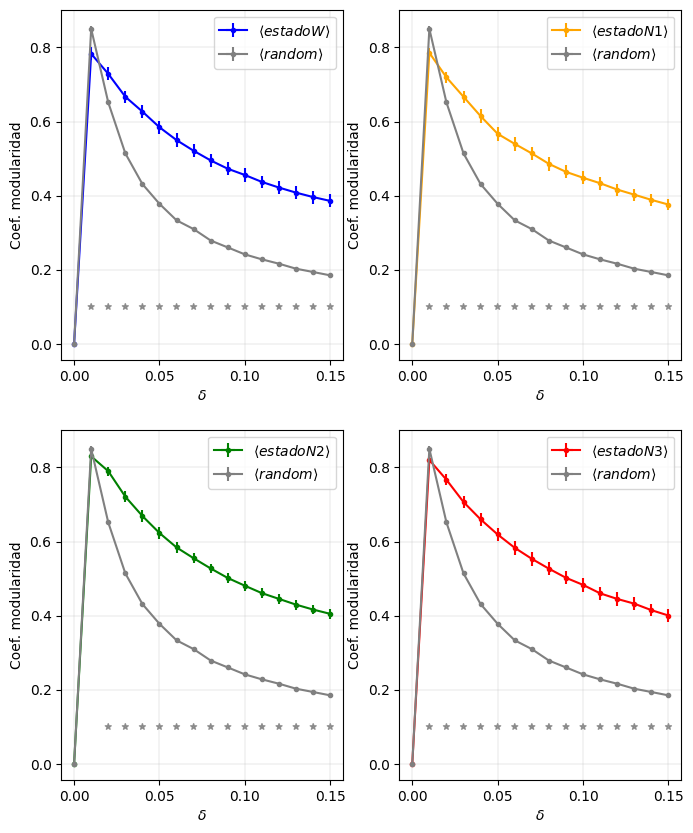

In [62]:
# Grafico

p_val = np.repeat(0.1,16)

fig, ax = plt.subplots(2,2, figsize=(8,10))

ax[0,0].errorbar(densidades_mod,W_mod_mean, xerr = 0, yerr = W_mod_sem, marker = '.', color = 'blue', ls = '-', label=r"$\langle estado W \rangle$")
ax[0,0].errorbar(densidades_mod,mod_rand_mean, xerr = 0, yerr = mod_rand_sem, marker = '.', color = 'gray', ls = '-', label=r"$\langle random \rangle$")
ax[0,0].scatter(densidades_mod, p_val, s= p_vals_W_rand * 20, color = 'gray',alpha= 0.8, marker = '*')

ax[0,1].errorbar(densidades_mod,N1_mod_mean, xerr = 0, yerr = N1_mod_sem,marker = '.',  color = 'orange', ls = '-', label=r"$\langle estado N1 \rangle$")
ax[0,1].errorbar(densidades_mod,mod_rand_mean, xerr = 0, yerr = mod_rand_sem, marker = '.', color = 'gray', ls = '-', label=r"$\langle random \rangle$")
ax[0,1].scatter(densidades_mod, p_val, s= p_vals_N1_rand * 20, color = 'gray',alpha= 0.8, marker = '*')

ax[1,0].errorbar(densidades_mod,N2_mod_mean, xerr = 0, yerr = N2_mod_sem, marker = '.', color = 'green', ls = '-', label=r"$\langle estado N2 \rangle$")
ax[1,0].errorbar(densidades_mod,mod_rand_mean, xerr = 0, yerr = mod_rand_sem, marker = '.', color = 'gray', ls = '-', label=r"$\langle random \rangle$")
ax[1,0].scatter(densidades_mod, p_val, s= p_vals_N2_rand * 20, color = 'gray',alpha= 0.8, marker = '*')

ax[1,1].errorbar(densidades_mod,N3_mod_mean, xerr = 0, yerr = N3_mod_sem,marker = '.', color = 'red', ls = '-', label=r"$\langle estado N3 \rangle$")
ax[1,1].errorbar(densidades_mod,mod_rand_mean, xerr = 0, yerr = mod_rand_sem, marker = '.', color = 'gray', ls = '-', label=r"$\langle random \rangle$")
ax[1,1].scatter(densidades_mod, p_val, s= p_vals_N3_rand * 20, color = 'gray',alpha= 0.8, marker = '*')

ax[0,0].set_xlabel("$\delta$")
ax[0,1].set_xlabel("$\delta$")
ax[1,0].set_xlabel("$\delta$")
ax[1,1].set_xlabel("$\delta$")

ax[0,0].set_ylabel("Coef. modularidad")
ax[0,1].set_ylabel("Coef. modularidad")
ax[1,0].set_ylabel("Coef. modularidad")
ax[1,1].set_ylabel("Coef. modularidad")

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].grid(linewidth=0.2)
ax[0,1].grid(linewidth=0.2)
ax[1,0].grid(linewidth=0.2)
ax[1,1].grid(linewidth=0.2)

plt.show()

### Variación de cantidad de comunidades en función de δ. Curvas promedio (entre individuos)

In [63]:
def cant_comunidades_grafos(matAdyacPesada, densidad):
    G = matrizAdyacenciaBinaria(matAdyacPesada, densidad)
    # M = cl.best_partition(G) # malena
    M = nx.community.louvain_communities(G)
    # devuelve coef de modularidad y numero de nodos y enlaces para cada grafo
    # return len(set(M.values())), G.number_of_edges() # Malena
    return len(M), G.number_of_edges()

com_W = np.zeros((len(W), len(densidades_mod)))
edges_W = np.zeros((len(W),len(densidades_mod)))

for i, densidad in enumerate(densidades_mod):
    for j, grafo in W.items():
      com_W[j-1,i],edges_W[j-1,i] = cant_comunidades_grafos(grafo, densidad)

com_N1 = np.zeros((len(N1), len(densidades_mod)))
#edges_N1 = np.zeros((len(N1),len(densidades_mod)))

for i, densidad in enumerate(densidades_mod):
    for j, grafo in N1.items():
      com_N1[j-1,i],_ = cant_comunidades_grafos(grafo, densidad)

com_N2 = np.zeros((len(N2), len(densidades_mod)))
#edges_N2 = np.zeros((len(N2),len(densidades_mod)))

for i, densidad in enumerate(densidades_mod):
    for j, grafo in N2.items():
      com_N2[j-1,i],_  = cant_comunidades_grafos(grafo, densidad)

com_N3 = np.zeros((len(N3), len(densidades_mod)))
#edges_N3 = np.zeros((len(N3),len(densidades_mod)))

for i, densidad in enumerate(densidades_mod):
    for j, grafo in N3.items():
      com_N3[j-1,i],_  = cant_comunidades_grafos(grafo, densidad)

In [64]:
# Genero grafos random y calculo n de comunidades
def cant_com_grafos_random(cant_nodos, cant_enlaces):
  G = nx.gnm_random_graph(cant_nodos,cant_enlaces)
  # M = cl.best_partition(G) # Malena
  M = nx.community.louvain_communities(G)
  # devuelve coef de modularidad y numero de nodos y enlaces para cada grafo
  # return len(set(M.values())) # Malena
  return len(M)

In [65]:
com_rand = np.zeros((len(edges_W), len(edges_W[0])))

for i in range(0,len(com_rand[0])):
  for j in range(0,len(com_rand)):
     com_rand[j,i] = cant_com_grafos_random(W_mean.shape[0], edges_W[j,i])

In [66]:
# Calculo medidas para el gráfico

W_com_mean = np.mean(com_W, axis = 0)
N1_com_mean = np.mean(com_N1, axis = 0)
N2_com_mean = np.mean(com_N2, axis = 0)
N3_com_mean = np.mean(com_N3, axis = 0)
com_rand_mean = np.mean(com_rand, axis = 0)

W_com_sem = np.std(com_W, axis = 0, ddof=1) / np.sqrt(np.size(com_W, axis = 0))
N1_com_sem = np.std(com_N1, axis = 0, ddof=1) / np.sqrt(np.size(com_N1, axis = 0))
N2_com_sem = np.std(com_N2, axis = 0, ddof=1) / np.sqrt(np.size(com_N2, axis = 0))
N3_com_sem = np.std(com_N3, axis = 0, ddof=1) / np.sqrt(np.size(com_N3, axis = 0))
com_rand_sem = np.std(com_rand, axis = 0, ddof=1) / np.sqrt(np.size(com_rand, axis = 0))

In [67]:
# Calculo tests estadísticos t de Welch y genero vectores para graficar significatividad

# import scipy.stats as stats

# W vs. random
p_vals_W_rand =[]

for i in range(len(com_W[0])):
  p_vals_W_rand.append(round(stats.ttest_ind(com_W[:,i], com_rand[:,i], equal_var = False)[1],3))

p_vals_W_rand = (np.array(p_vals_W_rand) < 0.05).astype(int)

# N1 vs. random
p_vals_N1_rand =[]

for i in range(len(com_N1[0])):
  p_vals_N1_rand.append(round(stats.ttest_ind(com_N1[:,i], com_rand[:,i], equal_var = False)[1],3))

p_vals_N1_rand = (np.array(p_vals_N1_rand) < 0.05).astype(int)


# N2 vs. random
p_vals_N2_rand =[]

for i in range(len(com_N2[0])):
  p_vals_N2_rand.append(round(stats.ttest_ind(com_N2[:,i], com_rand[:,i], equal_var = False)[1],3))

p_vals_N2_rand = (np.array(p_vals_N2_rand) < 0.05).astype(int)

# N3 vs. random
p_vals_N3_rand =[]

for i in range(len(com_N3[0])):
  p_vals_N3_rand.append(round(stats.ttest_ind(com_N3[:,i], com_rand[:,i], equal_var = False)[1],3))

p_vals_N3_rand = (np.array(p_vals_N3_rand) < 0.05).astype(int)

/home/vbettachini/bin/jupyter/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


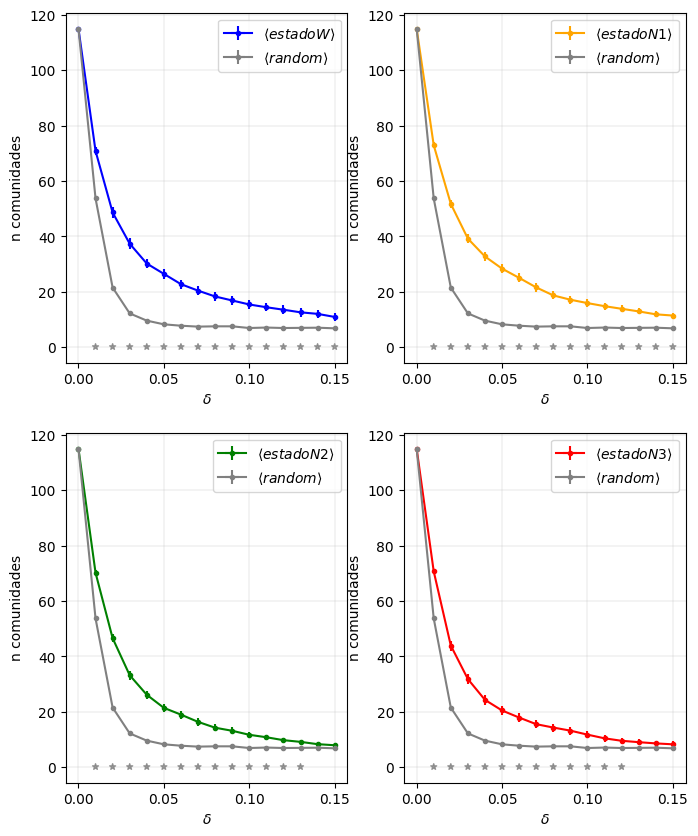

In [68]:
# Grafico

p_val = np.repeat(0.1,16)

fig, ax = plt.subplots(2,2, figsize=(8,10))

ax[0,0].errorbar(densidades_mod,W_com_mean, xerr = 0, yerr = W_com_sem, marker = '.', color = 'blue', ls = '-', label=r"$\langle estado W \rangle$")
ax[0,0].errorbar(densidades_mod,com_rand_mean, xerr = 0, yerr = com_rand_sem, marker = '.', color = 'gray', ls = '-', label=r"$\langle random \rangle$")
ax[0,0].scatter(densidades_mod, p_val, s= p_vals_W_rand * 20, color = 'gray',alpha= 0.8, marker = '*')

ax[0,1].errorbar(densidades_mod,N1_com_mean, xerr = 0, yerr = N1_com_sem,marker = '.',  color = 'orange', ls = '-', label=r"$\langle estado N1 \rangle$")
ax[0,1].errorbar(densidades_mod,com_rand_mean, xerr = 0, yerr = com_rand_sem, marker = '.', color = 'gray', ls = '-', label=r"$\langle random \rangle$")
ax[0,1].scatter(densidades_mod, p_val, s= p_vals_N1_rand * 20, color = 'gray',alpha= 0.8, marker = '*')

ax[1,0].errorbar(densidades_mod,N2_com_mean, xerr = 0, yerr = N2_com_sem, marker = '.', color = 'green', ls = '-', label=r"$\langle estado N2 \rangle$")
ax[1,0].errorbar(densidades_mod,com_rand_mean, xerr = 0, yerr = com_rand_sem, marker = '.', color = 'gray', ls = '-', label=r"$\langle random \rangle$")
ax[1,0].scatter(densidades_mod, p_val, s= p_vals_N2_rand * 20, color = 'gray',alpha= 0.8, marker = '*')

ax[1,1].errorbar(densidades_mod,N3_com_mean, xerr = 0, yerr = N3_com_sem,marker = '.', color = 'red', ls = '-', label=r"$\langle estado N3 \rangle$")
ax[1,1].errorbar(densidades_mod,com_rand_mean, xerr = 0, yerr = com_rand_sem, marker = '.', color = 'gray', ls = '-', label=r"$\langle random \rangle$")
ax[1,1].scatter(densidades_mod, p_val, s= p_vals_N3_rand * 20, color = 'gray',alpha= 0.8, marker = '*')

ax[0,0].set_xlabel("$\delta$")
ax[0,1].set_xlabel("$\delta$")
ax[1,0].set_xlabel("$\delta$")
ax[1,1].set_xlabel("$\delta$")

ax[0,0].set_ylabel("n comunidades")
ax[0,1].set_ylabel("n comunidades")
ax[1,0].set_ylabel("n comunidades")
ax[1,1].set_ylabel("n comunidades")

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].grid(linewidth=0.2)
ax[0,1].grid(linewidth=0.2)
ax[1,0].grid(linewidth=0.2)
ax[1,1].grid(linewidth=0.2)

plt.show()